stages of file generatation and usage

1. initial file by opening, creating empty data sets for markers and channels, storing meta data (file id, anything else?)
       - def h5_init(bam_name)

2. Write marker info and channels to file -- hopefully auto chunking will be fast and effecient. Assuming it's not too slow, I think writing all loci to file is best, filtering out what sites to use can be decided in subsequent steps. lot a memory potentially.


3. construct a common set of loci by inserting empty channels as needed. will need to make choices about filtering at the same stage. this seems like the most challening part (pho king A)



unaddressed challenges

- need to modify marker names to account for inserts -- perhaps change them to be format: chrom ipos? as in "A i10"?

- how to effeciently insert empty channels where individuals don't match --- sheesh. this chunk of code may help:

penta_ex = make_penta(seq_str, qual_str, depth_str, "T", qual_min=0)
print(penta_ex)
penta_ex = np.insert(penta_ex, obj = [0, 0], values = -999, axis=0)
penta_ex.shape




In [ ]:
import h5py
import numpy as np
import os

os.chdir("/home/silastittes/Dropbox/penta_channel/")


In [ ]:
def init_penta(bam_in, h5_out):

    with h5py.File(h5_out, 'w') as f:

        channels = f.create_dataset('channels', (0, 0), maxshape=(None,None), dtype='f8', chunks=True)
        makers = f.create_dataset('markers', (0, 0), maxshape=(None,2), dtype = 'S100', chunks=True)

        metadata = {'id': bam_in
                   }
        f.attrs.update(metadata)
        
def add_pentas(h5_out, penta_arr, marker_arr):
    try:
        with h5py.File(h5_out, 'a') as f:
            channels = f['channels']
            ch_end = channels.shape[0]
            
            shp = channels.shape[0] + penta_arr.shape[0]
            channels.resize((shp, 5))    
            channels[ch_end:shp] = penta_arr 
            
            markers = f['markers']
            mrk_end = markers.shape[0]
            mrk_shp = markers.shape[0] + marker_arr.shape[0]
            markers.resize((mrk_shp, 2))
            markers[mrk_end:mrk_shp] = marker_arr
            
    except FileNotFoundError:
        print("{0} not found".format(h5_out))

        
#older version        
def make_penta(seq_str, qual_str, depth_str, ref, qual_min = 50):
    seq_str = seq_str.upper()
    nuc_dict = {"A":0, "T":1, "G":2, "C":3, "*":4}
    nucs = {"A": 0, "T": 0, "G":0, "C":0, "*":0}

    if depth_str == "0" and seq_str == "*" and qual_str == "*":
        seq_channel = [[0,0,0,0,0]]
        #return np.array(seq_channel)
        return seq_channel

    else:
        i = 0
        q = 0
        inserts = list()
        gaps = list()

        while len(seq_str) > i:
            if seq_str[i] == "$": i += 1
            if seq_str[i] == "^": i += 2
            if seq_str[i] in [".", ","]:
                if ord(qual_str[q]) > qual_min:
                    nucs[ref] += 1
                q += 1

            if seq_str[i] in nucs:
                if ord(qual_str[q]) > qual_min:
                    nucs[seq_str[i]] += 1
                q += 1

            if seq_str[i] in ["+"]:
                i += 1
                j = 0
                insert_str = ""
                while seq_str[i].isnumeric():
                    insert_str += seq_str[i]
                    i += 1
                    j += 1
                insert_int = int(insert_str)
                insert_seq = seq_str[i:i + insert_int]
                while len(inserts) < insert_int:
                    inserts.append([0,0,0,0,0])

                for s in range(len(insert_seq)):
                    inserts[s][nuc_dict[insert_seq[s]]] +=1

                i += len(insert_str) + insert_int - 2

            if seq_str[i] in ["-"]:
                i += 1
                j = 0
                gap_str = ""
                while seq_str[i].isnumeric():
                    gap_str += seq_str[i]
                    i += 1
                    j += 1
                gap_int = int(gap_str)

                i += len(gap_str) + gap_int - 2
            i += 1

        seq_channel = list(nucs.values())
        inserts.insert(0,seq_channel)
        #return np.array(inserts)
        return inserts

    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
    #IUFHIUHWIUFHWDF
    
    
    
    

#newer version SEEMS TO BE WORKING, BUT MORE TESTS NEEDED!!!
def make_penta(seq_str, qual_str, depth_str, ref, qual_min = 50):
    seq_str = seq_str.upper()
    
    nuc_dict = {"A":0, "T":1, "G":2, "C":3, "*":4, "N":5}
    nucs = {"A": 0, "T": 0, "G":0, "C":0, "*":0, "N":0}
    inserts = {"A": 0, "T": 0, "G":0, "C":0, "*":0, "N":0}
    
    if depth_str == "0" and seq_str == "*" and qual_str == "*":
        seq_channel = [[0,0,0,0,0], [0,0,0,0,0]]
        return seq_channel
    
    else:
        i = 0
        q = 0
        while i < len(seq_str):
            if seq_str[i] == "$": 
                i += 1
            elif seq_str[i] == "^": 
                i += 2
                
            elif seq_str[i] in [".", ","]:
                if ord(qual_str[q]) > qual_min:
                    nucs[ref] += 1
                i += 1
                q += 1

            elif seq_str[i] in nucs:
                if ord(qual_str[q]) > qual_min:
                    nucs[seq_str[i]] += 1
                i += 1
                q += 1

                
            elif seq_str[i] == "+":
                i += 1
                j = 0
                insert_str = ""
                while seq_str[i].isnumeric():
                    insert_str += seq_str[i]
                    i += 1
                    j += 1
                insert_int = int(insert_str)
                insert_seq = seq_str[i:i + insert_int]
                i += insert_int

                for s in range(len(insert_seq)):
                    inserts[insert_seq[s]] += 1

            elif seq_str[i] == "-":
                i += 1
                j = 0
                gap_str = ""
                while seq_str[i].isnumeric():
                    gap_str += seq_str[i]
                    i += 1
                    j += 1
                gap_int = int(gap_str)
                i += gap_int
                
        seq_channel = [list(nucs.values())[0:5], list(inserts.values())[0:5]]
        #seq_channel = [list(nucs.values()), list(inserts.values())]
        return seq_channel



In [ ]:
init_penta("data/bam/no.bam", "data/h5/test.h5")

In [ ]:
ref = "A"
qual_min = 0



#seq_str = "*$.$.$.$.$.$.+5AGACT.+5AGACT.+5AGACT.+5AGACT.+5AGACT,+5agact.+5AGACT.+5AGACT.+5AGACT.+5AGACT.+5AGACT.+5AGACT"
#qual_str = "221102222222222222"
#depth_str = len(qual_str)

#seq_str = "*"
#qual_str = "*"
#depth_str = "0"

seq_str = ",.$.....,*.,.,...,,,.,..^+."
qual_str = "<<<22<<<<<<<<<<<2<;<172#"
depth_str = len(qual_str)

seq_str = "*+3AGG**a*G**+3AGG+4TTTT-5gccttcA"
seq_str = "***a*G+3TTT**cA"
qual_str = "222222222%"
depth_str = len(qual_str)

seq_str = ".G$,+6ACAACC-3CCC-1A^~.+5AAAAA+3AAA-6AAAAAA"
qual_str = "AAAA"
depth_str = "4"


#seq_str = "AA+10ATGC*ATGC*GC"
#qual_str = "2222"
#depth_str = "0"


make_penta(seq_str, qual_str, depth_str, ref = "N", qual_min=0)


In [ ]:
with h5py.File("src/test.h5", 'a') as f:
    channels = f['channels']
    ch = channels[:]  
    markers = f['markers']
    mrk = markers[:]  
print(ch, "\n", mrk)

with h5py.File("src/test2.h5", 'a') as f:
    channels = f['channels']
    ch2 = channels[:]  
    markers = f['markers']
    mrk = markers[:]  
print(ch2, "\n", mrk)

np.mean(ch == ch2)
print(ch.shape, ch2.shape)

In [ ]:
c1 = make_penta(seq_str, qual_str, depth_str, ref, qual_min=0)
chrom = "ch"
pos = "1"
mrk_init = [[chrom, pos]]
mrk_init.append([chrom, pos])
np.array([[chrom, "i"+str(int(pos)+ i)] for i in range(len(c1))], dtype = "S100")
c1

ll = []
ll.append(1)
ll

In [ ]:
def fasta_dict(file_name = "seqs.fa"):
    seq_dict = dict()
    with open(file_name) as fa:
        for ln in fa:
            line = ln.strip()
            if line and line[0] == ">":
                seq_name = line[1:]
                if seq_name not in seq_dict:
                    seq_dict[seq_name] = ""
                else:
                    raise ValueError("Fasta headers are not unique.")
            else:
                seq_dict[seq_name] += ln.strip()
    return seq_dict

def make_fastas(file_name = 'seqs.fa'):    
    fastas = fasta_dict("notebooks/seqs.fa")
    for name, seq in fastas.items():
        with open('seq_{0}.fa'.format(name), 'w+') as out_file:
            out_file.write(">reference_{0}\n{1}\n".format(name, seq))
        
#make_fastas("notebooks/seqs.fa")

make_fastas("notebooks/seqs.fa")

In [11]:
import numpy as np
from scipy.spatial import distance as dist
import h5py
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt


#pdist returns unique pairwise euclidean distances, 
    #so mean is sum of these divided by the number of them
def penta_pi(penta):
     return np.mean(dist.pdist(penta)) 


def penta_fst(*penta, scale = True):
    if scale:
        pi_t = penta_pi(np.concatenate(penta))
        p_mean = pi_t.mean()
        p_std = pi_t.std()
        pi_s = np.mean(np.array([penta_pi(i) for i in penta]))
        return 1 - (pi_s/pi_t)
    else:
        pi_t = penta_pi(np.concatenate(penta))
        pi_s = np.mean(np.array([penta_pi(i) for i in penta]))
        return 1 - (pi_s/pi_t)


def penta_T(*penta):
    pi_s = np.mean(np.array([penta_pi(i) for i in penta]))
    pi_t = penta_pi(np.concatenate(penta))
    return -np.log(pi_s/pi_t)

def penta_PBS(focal, out1, out2):
    T_fo1 = penta_T(focal, out1)
    T_fo2 = penta_T(focal, out2)
    T_o12 = penta_T(out1, out2)
    return  (T_fo1 + T_fo2 - T_o12 )/2
        
def penta_PBE(focal, out1, out2, PBS_med, Tmed_o12):
    PBS_obs = penta_PBS(focal, out1, out2)
    PBS_exp = (penta_T(out1, out2) * PBS_med/Tmed_o12)
    return PBS_obs - PBS_exp

n = 5
sc = 1
a = np.random.normal(scale = sc, size = (n,5))
b = np.random.normal(scale = sc, size = (n,5))
c = np.random.normal(scale = sc, size = (n,5))

penta_pi(a)
penta_fst(a, b, c)
penta_T(a, b, c)
penta_PBS(a, b, c)


# Python Program illustrating  
# numpy.quantile() method  
  
# 1D array  
arr = [20, 2, 7, 1, 34] 
  
print("arr : ", arr)  
print("Q2 quantile of arr : ", np.percentile(arr, [1,2,10])) 

arr :  [20, 2, 7, 1, 34]
Q2 quantile of arr :  [1.04 1.08 1.4 ]


(100, 2) (100,)


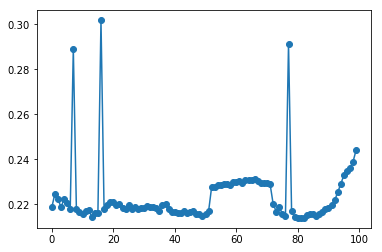

In [40]:

h5_ex = glob("/home/silastittes/Dropbox/gfidl/penta_sim/penta/*h5")


#starts and ends will be determined by looping through the cds bedfile, but simple list here for practice
wind = 200
starts = range(0, 1000 - wind, wind)
ends =  [i + wind for i in starts ]
j=1

gene = []
mrks = []
for i in h5_ex:
    with h5py.File(i, 'r') as f:
        channels = f['channels']
        ch2 = channels[starts[j]:ends[j], :]
        markers = f['markers']
        mrk2 = markers[starts[j]:ends[j], :]
        #ch2 = channels[:]
    gene.append(ch2)
    mrks.append(mrk2)
gene = np.array(gene)
mrks = np.array(mrks)

fst = []
fst_mrk = []
#for i in range(0, gene.shape[1], 2): #for sequence channels only
for i in range(0, gene.shape[1]):    
    cgene = gene[:,i,:]
    mean_g = np.mean(cgene)
    sd_g = np.std(cgene)
    if sd_g != 0: 
        cgene_scl =  (cgene - mean_g) / sd_g   
        #c_fst = penta_fst(cgene_scl[0:5], cgene_scl[5:])
        c_fst = penta_PBE(cgene_scl[0:5], cgene_scl[5:], cgene_scl[5:], 0.2, 0.1)
        fst.append(c_fst)
        fst_mrk.append(mrks[0, i, :])
    
fst = np.array(fst)
fst_mrk = np.array(fst_mrk)
plt.plot(fst, "-o")

print(fst_mrk.shape, fst.shape)

In [4]:
np.array(([1,2,4], [1,2,7]))

array([[1, 2, 4],
       [1, 2, 7]])

In [ ]:
#okay, can calc fst. I'll need to know how to group individuals into populations

n = 9
gene = [np.random.normal(size = (3, 5)) for i in range(n) ]
gene = np.array(gene)

for i in range(gene.shape[1]):
    cgene = gene[:,i,:]
    cgene_scl = (cgene - np.mean(cgene)) / np.std(cgene)
    
    #need to decide how to group individuals at a locus here!
    print(penta_fst(cgene_scl[:3, :], cgene_scl[3:6, :], cgene_scl[6:9, :]))

In [327]:
### if sd_g == 0:
#    ace =  np.zeros(cgene_scl.shape)
    

tt = np.array([[0,3,0,0,0], [0,1,0,0,0], [0,2,0,0,0]])
tt2 = np.array([[0,1,0,0,0], [0,5,0,0,0], [0,6,0,0,0]])
tt_b = np.concatenate((tt, tt2))

hs1 = np.mean([(np.mean(dist.pdist(i)) - tt_b.mean())/tt_b.std() for i in (tt, tt2)])
ht1 = np.mean(dist.pdist( tt_b - tt_b.mean())/tt_b.std() )
hs2 = np.mean([np.mean(dist.pdist(i)) for i in (tt, tt2)])
ht2 = np.mean(dist.pdist(tt_b))


np.mean(dist.pdist((tt_b - tt_b.mean())/tt_b.std()))

tmean = tt_b.mean(axis = 0)
#if sd_g == 0:
#    ace =  np.zeros(cgene_scl.shape)
    

#tt = np.array([[0,3,0,0,0], [0,1,0,0,0], [0,2,0,0,0]])
#tt2 = np.array([[0,1,0,0,0], [0,5,0,0,0], [0,6,0,0,0]])
tt = np.random.normal(size = (10,5))
tt2 = np.random.normal(size = (10,5))
#tt_b = np.array((tt, tt2))
tt_b = np.concatenate((tt, tt2))
tmean = tt_b.mean(axis = 0)
tstd = tt_b.std(axis = 0) + 1

met = 'seuclidean'

hs1 = np.mean([np.mean(dist.pdist((i - tmean)/tstd, metric = met)) for i in (tt, tt2)])
ht1 = np.mean(dist.pdist( (tt_b - tmean)/tstd, metric = met))
hs2 = np.mean([np.mean(dist.pdist(i, metric = met)) for i in (tt, tt2)])
ht2 = np.mean(dist.pdist(tt_b, metric = met))
print(
    1 - (hs1/ht1),
    1- (hs2/ht2)
)

#np.mean(dist.pdist((tt_b - tt_b.mean())/tt_b.std()))

#tmean = tt_b.mean(axis = 0)
#tstd = tt_b.std(axis = 0) + 1
#(tt_b - tmean)/tstd

#print(hs1, ht1)


-0.008014431699044255 -0.008014431699044477


need to think through next steps

open h5 files, reading in 1 gene at a time according to bed file converted positions in 

`/group/jrigrp10/stittes/hilo_2_sorghum/data/ref/cds_penta_sites.bed`

couple things to remember here:

-the channels aren't scaled, but shouldn't be until all individauls have data loaded for a gene

-there are sequence channels and insertion channels -- insertion channels have a lot of zeros. might be worth doing some calculations across genes with and without these sites included! 

-lots of missing data, so calculating per site and per gene would be valuable

the process will look something like: 

with open("cds_penta_sites.bed", "r") as f:
    sites = f.strip().split()
    start, end = sites[1:3]
    gene = [] #hopefully the dimensions are right here??
    h5py.File(file_name, "r") as h5:
        gene_penta = h5['channels'][start:end]
        gene.append(gene_penta)
        
    scale across inds at locus
    calculate fst at locus
    calculate average fst across whole gene    

    
 most of the above is looking good for simulated data, next challenge will be calculating the PBS and PBE stats 
 
Tricky parts stem mostly from the specific groups that the stats are calculated for. need to calculate FST for different highland focal groups, paired with lowland and parviglumis pops.
I think making csv files that instruct what h5 belong to what populations will work well, but lots of places to be careful.

In [340]:
def penta_T(*penta, scale = True, FST = False, dist_metric = "euclidean"):
    if scale:    
        t = np.concatenate(penta)
        t_mean = t.mean(axis = 0)
        t_std = t.std(axis = 0)+1
        pi_s = np.mean([penta_pi( (i - t_mean)/t_std ) for i in penta])
        pi_t = penta_pi( (t - t_mean)/t_std)
    else:
        pi_s = np.mean(np.array([penta_pi(i) for i in penta]))
        pi_t = penta_pi(np.concatenate(penta))
    if FST:
        return 1 - (pi_s/pi_t)
    else:
        return -np.log(pi_s/pi_t)

n = 5
sc = 1
a = np.random.normal(scale = sc, size = (n,5))
b = np.random.normal(scale = sc, size = (n,5))
c = np.random.normal(scale = sc, size = (n,5))

print( 
#penta_pi(a),
#penta_fst(a, b, c),
penta_T(a, b, c, scale = False),
penta_T(a, b, c, metric = "minkowski"),
#penta_PBS(a, b, c)
)
    

TypeError: penta_T() got an unexpected keyword argument 'metric'